In [29]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# cargar los datos
df = pd.read_json('/content/drive/MyDrive/datassets/finanzas/milnoticias/News_Category_Dataset_v2.json', lines=True)

# cargar las palabras vacías
palabras_vacias = [linea.rstrip('\n') for linea in open('/content/drive/MyDrive/datassets/finanzas/milnoticias/palabras_vacias.txt')]


In [5]:
# limpiar el corpus
def remove_sw(t):
  tokens = t.strip().split(' ')
  tokens = [token for token in tokens if token not in palabras_vacias]
  tout = ' '.join(tokens).strip()
  return tout

def clean_text(t):
  t = str(t)
  t = re.sub(r'\d+',' ',t)
  t = re.sub(r'[^\w\n]',' ',t)
  t = re.sub(r'\s\s+',' ',t)
  t = t.lower()
  t = t.strip()
  return t

In [6]:
# inicializar los modelos
nmf = NMF(n_components=10)
lda = LatentDirichletAllocation(n_components=10)

In [7]:
# inicializar las listas para guardar los scores de Jaccard
scores_lda = []
scores_nmf = []

In [ ]:
# calcular los scores de Jaccard para cada review
for i in range(len(df)):
    # extraer la review original
    review = df.loc[i, 'short_description']
    
    # limpiar la review y extraer los stopwords
    review_clean = remove_sw(clean_text(review))
     
    #agreagar valor por default si la limpieza no devuelve vocabulario
    if not review_clean:
      continue

    # transformar la review limpia en una matriz TF-IDF
    try:
       tfidf = TfidfVectorizer().fit_transform([review_clean])
    except ValueError:
       continue
    
    # obtener las distribuciones de tópicos para cada modelo
    lda_distribution = lda.fit_transform(tfidf)
    nmf_distribution = nmf.fit_transform(tfidf)
    
    # obtener el tópico principal para cada modelo
    lda_topic = lda_distribution.argmax(axis=1)
    nmf_topic = nmf_distribution.argmax(axis=1)
    
    # calcular el score de Jaccard para cada modelo
    lda_score = 1 - pairwise_distances(lda.components_[lda_topic], tfidf.toarray(), metric='jaccard')
    nmf_score = 1 - pairwise_distances(nmf.components_[nmf_topic], tfidf.toarray(), metric='jaccard')
    
    # agregar los scores a las listas
    scores_lda.append(lda_score[0][0])
    scores_nmf.append(nmf_score[0][0])

    

In [25]:
#truncamos las listas para que coincidan con el DF
scores_lda_trunc = scores_lda[:len(df)]
scores_nmf_trunc = scores_nmf[:len(df)]

In [27]:
# asignar los scores a nuevas columnas en el DataFrame
df['LDAScore'] = scores_lda_trunc
df['NMFScore'] = scores_nmf_trunc

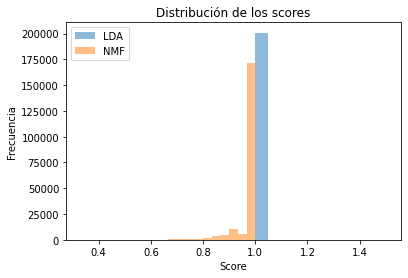

In [30]:
# graficar la distribución de los scores de LDA y NMF
plt.hist(df['LDAScore'], bins=20, alpha=0.5, label='LDA')
plt.hist(df['NMFScore'], bins=20, alpha=0.5, label='NMF')
plt.legend(loc='upper left')
plt.title('Distribución de los scores')
plt.xlabel('Score')
plt.ylabel('Frecuencia')
plt.show()

In [31]:
# calcular los promedios de los scores por modelo
lda_mean = df['LDAScore'].mean()
nmf_mean = df['NMFScore'].mean()

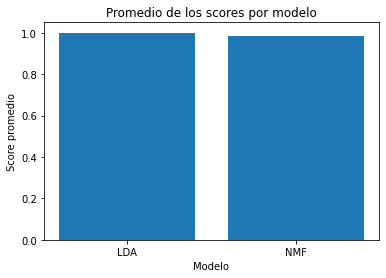

In [32]:
# graficar los promedios de los scores por modelo
plt.bar(['LDA', 'NMF'], [lda_mean, nmf_mean])
plt.title('Promedio de los scores por modelo')
plt.xlabel('Modelo')
plt.ylabel('Score promedio')
plt.show()

In [33]:
count_lda = 0
count_nmf = 0
for i in range(len(df)):
    if df.loc[i, 'LDAScore'] > df.loc[i, 'NMFScore']:
        count_lda += 1
    elif df.loc[i, 'LDAScore'] < df.loc[i, 'NMFScore']:
        count_nmf += 1

# imprimir cuál método es mejor
if count_lda > count_nmf:
    print("LDA es mejor")
elif count_lda < count_nmf:
    print("NMF es mejor")
else:
    print("Ambos métodos tienen el mismo rendimiento")

LDA es mejor
